In this workshop/tutorial we will apply a few explainability approaches to the diabetes dataset from sklearn. 

Structure of the notebook:
- Import libraries and data
- Train simple model
- Apply visual explanations: ICE plots and PDP plots
- Global surrogate model
- A transparent less known approach: RuleFit
- Local explanations: LIME and Shap


### Import libraries and data

In [1]:
#Import libraries

from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pycebox.ice as icebox
from sklearn.inspection import plot_partial_dependence
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from rulefit import RuleFit
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap

In [22]:
# Set some pandas options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = '{:.4f}'.format

In [23]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
raw_data = load_diabetes()
df = pd.DataFrame(np.c_[raw_data['data'], raw_data['target']],
                  columns= np.append(raw_data['feature_names'], ['target']))

Here is a reminder/description of the data, taken from the **sklearn** page(https://scikit-learn.org/stable/datasets/index.html): 

Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

In [20]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.04,0.05,0.06,0.02,-0.04,-0.03,-0.04,-0.00,0.02,-0.02,151.00
1,-0.00,-0.04,-0.05,-0.03,-0.01,-0.02,0.07,-0.04,-0.07,-0.09,75.00
2,0.09,0.05,0.04,-0.01,-0.05,-0.03,-0.03,-0.00,0.00,-0.03,141.00
3,-0.09,-0.04,-0.01,-0.04,0.01,0.02,-0.04,0.03,0.02,-0.01,206.00
4,0.01,-0.04,-0.04,0.02,0.00,0.02,0.01,-0.00,-0.03,-0.05,135.00


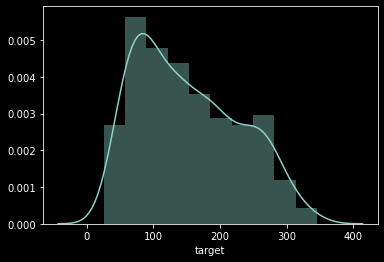

In [6]:
sns.distplot(df['target'])
plt.style.use('dark_background')

In [24]:
df.info() # There are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


<AxesSubplot:>

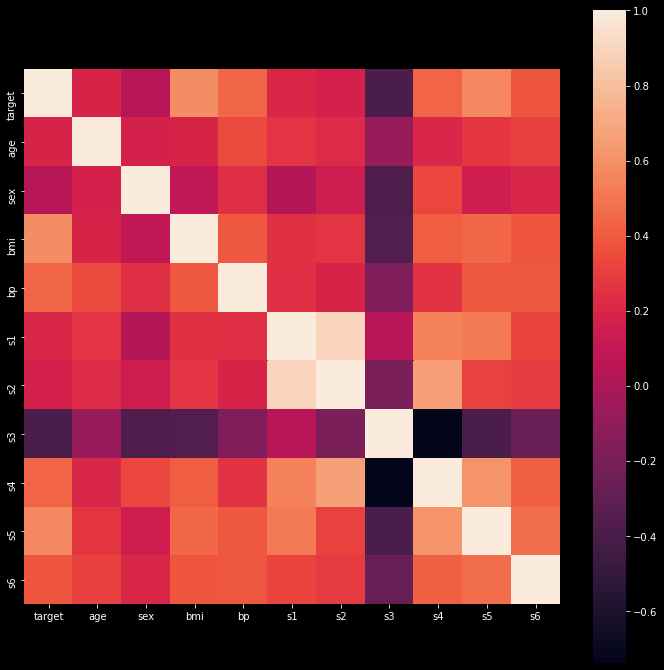

In [25]:
corrmat = pd.concat([df.loc[:, 'target'] ,df.iloc[:, :-1]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
plt.style.use('dark_background')
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

### Train a simple model

In [9]:
y = df.target
X = df.drop('target', axis=1)

In [10]:
# Train a model
clf = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1)
clf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

<AxesSubplot:>

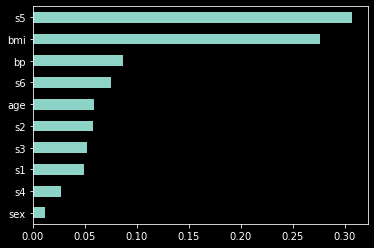

In [11]:
# Print the feature importances, standard after a tree-based model 
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh') 

In [26]:
feat_importances.sort_values(ascending=False).head()

s5    0.3065
bmi   0.2761
bp    0.0866
s6    0.0746
age   0.0587
dtype: float64

### Visual approaches

Among the visual explanations we will apply are ICE plots and PDP plots. 

Partial dependency plots shows how the average prediction changes as you change the feature(s) you are plotting. 
Individual independence (ICE) plots are similar to PDP plots but show one line per instance instead of the average. Thus they can uncover heterogeneous effects. 

______________________________________________________________

To plot ICE plots, we will use the **pycebox** package and its **ice** and **ice_plot** functions.

**ice** takes in a dataframe, a column of interest and model object, on which to predict. It returns a DataFrame with ICE curves for a model. The columns are ICE curves with the row index the independent variable (so chosen column) and the column index is the original data point corresponding to that ICE curve. 

To create PDP plots, we can also use the **pycebox** package. However, I will also utilise **sklearn.inspection**.

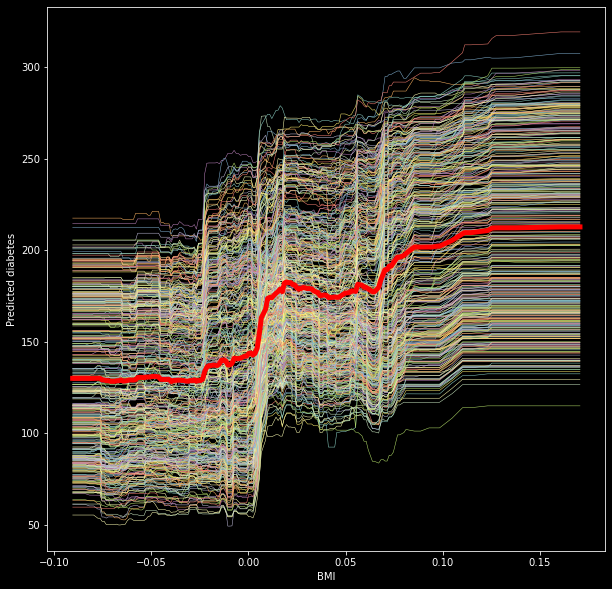

<Figure size 1080x1080 with 0 Axes>

In [13]:
# We feed in the X-matrix, the model and one feature at a time 
bmi_ice_df = icebox.ice(data=X, column='bmi', 
                   predict=clf.predict)

# Plot the figure
fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(figsize=(15, 15))
icebox.ice_plot(bmi_ice_df, linewidth=.5,  plot_pdp=True, 
         pdp_kwargs={'c': 'red', 'linewidth': 5}, ax=ax)
 
ax.set_ylabel('Predicted diabetes')
ax.set_xlabel('BMI')
fig.savefig('BMI_ICEplot.png')

We can also center the ICEplot, so that all lines start from the same point, i.e. remove level effects and make the figure more readable. 

Text(0.5, 0, 'BMI')

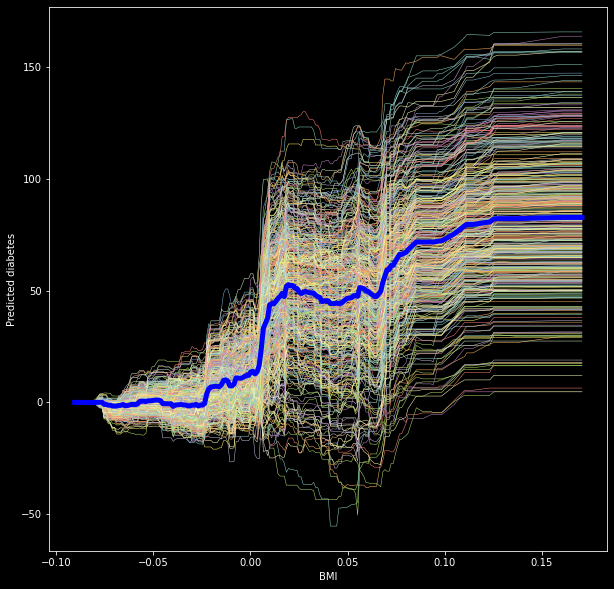

In [14]:
# There is an error in the __gen_quantiles() in the ice_plot, patch it below: 
def __get_quantiles(x):
    return np.greater.outer(x, x).sum(axis=1) / x.size
icebox.__get_quantiles = __get_quantiles

# Plot the centered figure
fig, ax1 = plt.subplots(figsize=(10, 10))
icebox.ice_plot(bmi_ice_df, linewidth=.5,  plot_pdp=True, 
         pdp_kwargs={'c': 'blue', 'linewidth': 5}, centered=True, ax=ax1)
 
ax1.set_ylabel('Predicted diabetes')
ax1.set_xlabel('BMI')

In [17]:
fig.savefig('BMI_ICEcentered.png')

The above plot is definitely more readable. Let's explore another feature. According to the feature importance after the random forest model *s5* is the most important feature. This is one of the features measuring the blood serum. 

Text(0.5, 0, 'S5')

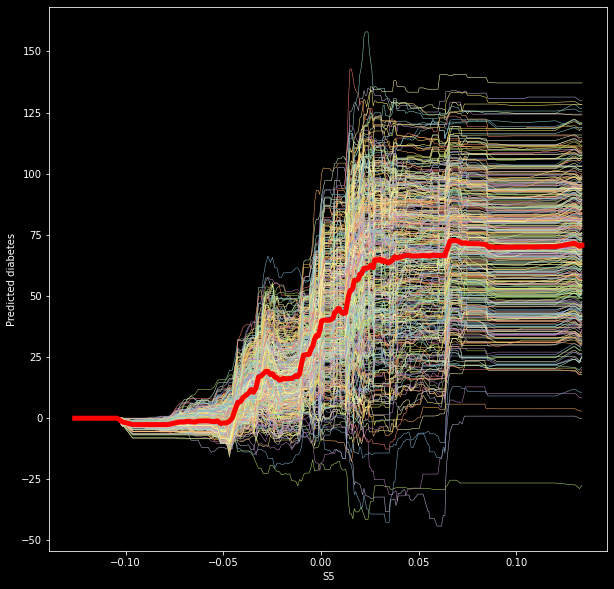

<Figure size 1080x1080 with 0 Axes>

In [15]:
s5_ice_df = icebox.ice(data=X, column='s5', 
                   predict=clf.predict)

# Plot the figure
fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(figsize=(15, 15))
icebox.ice_plot(s5_ice_df, linewidth=.5,  plot_pdp=True, centered=True,
         pdp_kwargs={'c': 'red', 'linewidth': 5}, ax=ax)
 
ax.set_ylabel('Predicted diabetes')
ax.set_xlabel('S5')

In [19]:
fig.savefig('s5_centeredICE.png')

### PDP plots

I will first work with the **sklearn.inspection** package. We can select a single feature to plot, a couple of features, or even create an interaction between 2 feature. We can have an interaction plot of 2 features at a time, not more. 

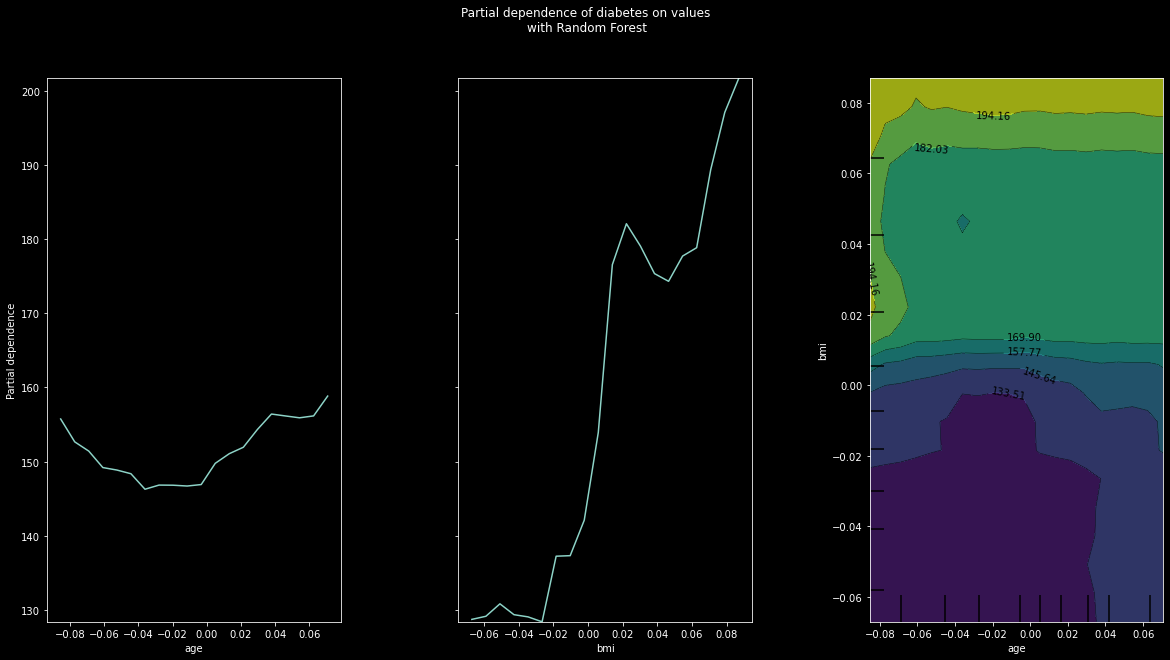

In [16]:
# Define features to include in the plots
features = ['age', 'bmi', ('age', 'bmi')]

fig, ax = plt.subplots(figsize=(20, 10))
plot_partial_dependence(estimator=clf, target=y,
                        X=X, #raw features data
                        features= features, fig=fig, grid_resolution=20) #columns we want to show
                                                
fig.suptitle('Partial dependence of diabetes on values \n'
              'with Random Forest')
fig.subplots_adjust(wspace=0.4, hspace=0.3)

In [21]:
fig.savefig('PDP_plot_bmi_age.png')

Anoter alternative is to continue working with the **pycebox** package. 

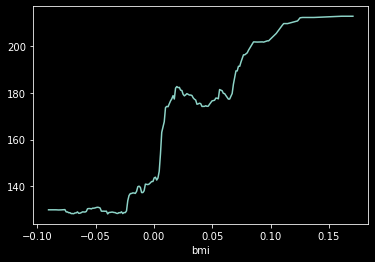

In [40]:
icebox.pdp(bmi_ice_df).plot()
plt.savefig('PDP_bmi_pycebox.png')

Looks very similar but it's less clear to me how one may do a PDP with interactions using the *pycebox* package. 

### Global surrogate model

Global surrogate models are quite straighforward. In this approach, we fit an interpretable model (such as a decision tree estimator or a linear/logistic regression) after the black box model. The one important factor we need to keep track of is how well the surrogate approximates the black box model. 

In [17]:
predictions = clf.predict(X)
dt = DecisionTreeRegressor(random_state = 100, max_depth=3)
dt.fit(X, predictions)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=100, splitter='best')

[Text(558.0, 475.65000000000003, 's5 <= -0.004\nmse = 4055.893\nsamples = 442\nvalue = 152.345'),
 Text(279.0, 339.75, 'bmi <= 0.006\nmse = 1793.689\nsamples = 218\nvalue = 111.426'),
 Text(139.5, 203.85000000000002, 's3 <= 0.025\nmse = 965.478\nsamples = 171\nvalue = 97.992'),
 Text(69.75, 67.94999999999999, 'mse = 1193.493\nsamples = 91\nvalue = 108.497'),
 Text(209.25, 67.94999999999999, 'mse = 437.788\nsamples = 80\nvalue = 86.042'),
 Text(418.5, 203.85000000000002, 'bp <= 0.024\nmse = 1761.652\nsamples = 47\nvalue = 160.3'),
 Text(348.75, 67.94999999999999, 'mse = 1151.053\nsamples = 32\nvalue = 147.762'),
 Text(488.25, 67.94999999999999, 'mse = 2013.367\nsamples = 15\nvalue = 187.049'),
 Text(837.0, 339.75, 'bmi <= 0.015\nmse = 3041.966\nsamples = 224\nvalue = 192.169'),
 Text(697.5, 203.85000000000002, 'bmi <= -0.023\nmse = 2042.661\nsamples = 116\nvalue = 162.802'),
 Text(627.75, 67.94999999999999, 'mse = 1386.356\nsamples = 41\nvalue = 140.916'),
 Text(767.25, 67.94999999999999, 'mse = 1996.426\nsamples = 75\nvalue = 174.767'),
 Text(976.5, 203.85000000000002, 'bmi <= 0.069\nmse = 2194.031\nsamples = 108\nvalue = 223.712'),
 Text(906.75, 67.94999999999999, 'mse = 1940.624\nsamples = 77\nvalue = 208.316'),
 Text(1046.25, 67.94999999999999, 'mse = 772.354\nsamples = 31\nvalue = 261.953')]

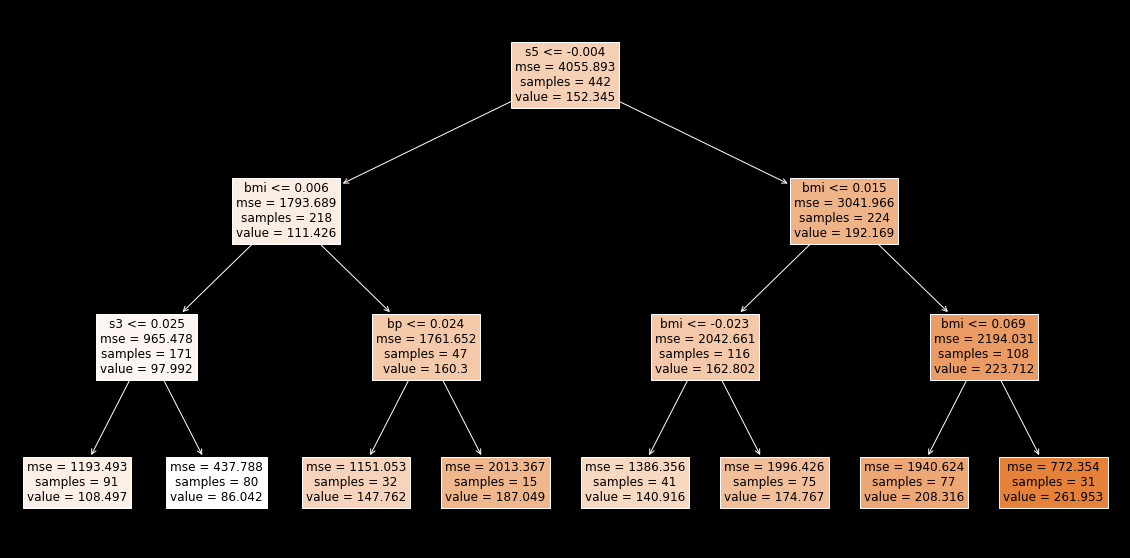

In [27]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(20, 10))

mpl.rcParams['text.color'] = 'black'
plot_tree(dt, feature_names=list(X.columns), precision=3, 
           filled=True, fontsize=12, impurity=True)

In [32]:
fig.savefig('surrogate_tree.png')

We need to keep track of how well the surrogate model approximates the black box model. One goos way to do that is to keep track of the R-squared for example. 

In [27]:
dt.score(X, predictions)

0.6705488147404473

It's unclear though whether this R-squared is high/good enough-- and this is one of the difficulties of surrogate models, deciding what is a good approximation.

### RuleFit

RuleFit is a transparent type of an algorithm. I am using Chrisoph Molanar's implementation (https://github.com/christophM/rulefit). 

In the first step, we generate sort of decision rules (examples: if x1 > 3 and x2 <5 then 1 else 0). The trees used for the generation of the rules are trained to predict the outcome. You want to generate diverse and meaningful rules. Basically RuleFit generates a new set of features from your original features.

Since this results in many new features being generated, in step 2 you fit a sparse linear model, such as a Lasso, using the original features and the generated rules. So the result is a linear model which will have linear effects for all of the original features and the rules.

Therefore, this is inherently a transparent algorithm but we have enriched the feature space by creating these rules/interactions.

In [28]:
# Create RuleFit
# Default tree_generator is GradientBoosting, but can pass also RandomForest or decision tree
rulefit = RuleFit(tree_generator=RandomForestRegressor(n_estimators = 100))
rulefit.fit(X.values, y, feature_names=X.columns)

RuleFit(Cs=None, cv=3, exp_rand_tree_size=True, lin_standardise=True,
        lin_trim_quantile=0.025, max_rules=2000, memory_par=0.01,
        model_type='rl', random_state=None, rfmode='regress',
        sample_fract='default',
        tree_generator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=5, max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=569, n_jobs=None,
                                             

The returned data set is sorted based on the support. Rules are first formed, then a L1 (LASSO) is trained using the rules and the original features. The coef is the coefficient in the Lasso regression. 

Some features apply are rules, others as linear terms. Type=linear for the original features and type=rule for the rule generated features.

Support is the percentage of data points to which the decision rule applies. For the original features, the support will be 1, for the rule generated ones not, it will be lower. 
 
 Feature importances are calculated slightly differently based on whether we have original feature or a rule, and then combining their contribution. 

In [32]:
rules = rulefit.get_rules()

rules.tail()

,rule,type,coef,support,importance
1292,bmi > 0.027206219732761383 & s5 <= -0.0037617861526086926,rule,0.0000,0.0783,0.0000
1293,bmi > 0.0029554484644904733 & s5 <= -0.010411696508526802,rule,-0.0000,0.1111,0.0000
1294,bmi > 0.0061888848431408405 & s5 <= 0.021657449193298817,rule,0.0000,0.1908,0.0000
1295,s5 <= 0.0015758189256303012 & bmi <= 0.007805602857843041,rule,-0.0000,0.4211,0.0000
1296,s5 > 0.00661808904260397 & bmi <= 0.01319466345012188,rule,-0.0000,0.1985,0.0000


In [33]:
# sort by support, i.e. will display original features on top
#rules = rules[rules.coef != 0].sort_values("support", ascending=False) #coef is the lasso coef 
                                                                          
# sort by descreasing feature importance
rules1 = rules.sort_values('importance', ascending=False)
for i in range(10):
    print(rules1.iloc[i, 0], ' type:', rules1.iloc[i,1], ' importance:', rules1.iloc[i, -1])

age > -0.08724666759371758 & bp <= 0.039086708799004555 & s5 <= 0.015935898758471012 & bmi <= 0.0061888848431408405  type: rule  importance: 7.55282118170138
s3 > 0.021027816459536552 & s5 <= 0.015935898758471012 & bmi <= 0.007805602857843041  type: rule  importance: 5.916742035834537
s5 <= 0.02638517413288355 & bmi <= 0.0061888848431408405 & s4 <= 0.02914270106703043  type: rule  importance: 5.7363704673196905
bmi > 0.005111072678118944 & s5 > -0.030139416456222534  type: rule  importance: 5.630622536020866
bp <= 0.037365272641181946 & s6 <= 0.03413021191954613 & age > -0.08361412957310677 & bmi > 0.0061888848431408405 & bmi <= 0.06870198622345924  type: rule  importance: 5.074881761316974
bmi > 0.005111072678118944 & bmi > 0.07301323488354683  type: rule  importance: 4.560907191489299
s5 > 0.013687931932508945 & s6 <= 0.04241442494094372 & bp <= 0.061465367674827576  type: rule  importance: 3.676732005301015
s2 <= 0.09858047962188721 & s5 <= -0.0037617861526086926  type: rule  import

In [34]:
rules1.head(10)

,rule,type,coef,support,importance
1115,age > -0.08724666759371758 & bp <= 0.039086708799004555 & s5 <= 0.015935898758471012 & bmi <= 0.0061888848431408405,rule,-15.5593,0.3801,7.5528
55,s3 > 0.021027816459536552 & s5 <= 0.015935898758471012 & bmi <= 0.007805602857843041,rule,-14.2966,0.2194,5.9167
865,s5 <= 0.02638517413288355 & bmi <= 0.0061888848431408405 & s4 <= 0.02914270106703043,rule,-11.7162,0.3986,5.7364
463,bmi > 0.005111072678118944 & s5 > -0.030139416456222534,rule,11.7028,0.3640,5.6306
615,bp <= 0.037365272641181946 & s6 <= 0.03413021191954613 & age > -0.08361412957310677 & bmi > 0.0061888848431408405 & bmi <= 0.06870198622345924,rule,-14.3334,0.1470,5.0749
616,bmi > 0.005111072678118944 & bmi > 0.07301323488354683,rule,17.7709,0.0709,4.5609
87,s5 > 0.013687931932508945 & s6 <= 0.04241442494094372 & bp <= 0.061465367674827576,rule,-8.4113,0.2572,3.6767
288,s2 <= 0.09858047962188721 & s5 <= -0.0037617861526086926,rule,-7.2018,0.4948,3.6007
164,s1 > 0.04796534217894077 & age > -6.574729923158884e-05 & s5 > -0.0037617861526086926 & s5 <= 0.044254669919610023 & bmi <= 0.05576823838055134,rule,-16.0036,0.0458,3.3447
185,s3 > -0.026833475567400455 & s5 > 0.00026727162185125053 & s1 > -0.02633611112833023 & bmi <= 0.009422320872545242,rule,-12.0467,0.0830,3.3243


### Local explanations

Among two of the most popular approaches for providing local explanations (i.e. explanaing the decision of the model for each instance in the data), are LIME and Shapley values. 

#### LIME

LIME: 1 ) generates a new dataset of permuted samples and corresponding predictions of the black box model; 2) trains an interpretable model on the new dataset, weighted by the proximity of the sampled instances to the instance of interest

It works on both regression and classification problems as well as with tabular data, text and images.

There are a couple of libraries that implement LIME. I will use the  **lime** package.

In [33]:
# Define a Lime explainer
explainer = LimeTabularExplainer(X, mode='regression', 
                                 feature_names=list(X.columns), 
                                 random_state=42, 
                                 discretize_continuous=False,
                                 kernel_width=2) 

Note that the local explanation is not dependent on the black box model -- we did not specify it anywhere!

In [34]:
# Generate explanations for the i-th row in the dataset: change the X.loc[] to change which row you select
# Can also select the number of features to use for that explanation, given by num_features

exp = explainer.explain_instance(X.iloc[0,:].values, 
                                 clf.predict, num_features=10)

In [35]:
exp.local_pred[0]

205.04083914696378

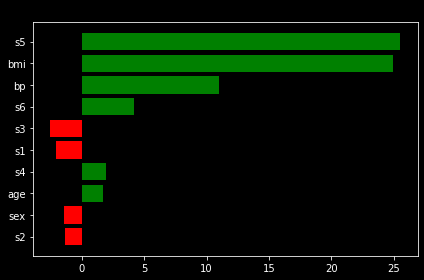

In [38]:
# We can also print the explantions for this instance
exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig('Lime_example.png')

In [39]:
# Or we can print them as a list
print(exp.as_list())

[('s5', 25.50973707854455), ('bmi', 24.971526283655322), ('bp', 10.962429220969678), ('s6', 4.201709903743039), ('s3', -2.5151538403380282), ('s1', -2.0615860797918213), ('s4', 1.9422107805141435), ('age', 1.6862797253754227), ('sex', -1.3985441274547672), ('s2', -1.366558492867371)]


We can see that the explanations for the same observation will change the kernel_width, for example, and/or the number of features we want to include in the explantion (which is to be expected).


This is my difficuly with LIME - there is no guidance on what would be correct kernel setting, and/or how many features you want to include there. 

#### Shapley values

The Shapley values calculate the marginal contribution of each feature on an instance level compared to the average prediction for the data set. It also works on classification and regression tasks, as well as on tabular, text and images.

It includes all of the features for each instance and ensure fair distriburion of the contributions of the features. 

I will work with the  **shap** package.

In [41]:
# explain the model's predictions using SHAP values
# This is the part that can take a while to compute with larger datasets

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

We can look at the Shapley values for one instance. We see how each feature's contribution is pushing the model's output from the base value to the model output for the concrete instance. In red are features that increase the contribution, and in blue- are those that decrease. We see the concrete values of the features for that one instance (below), and their contribution. 

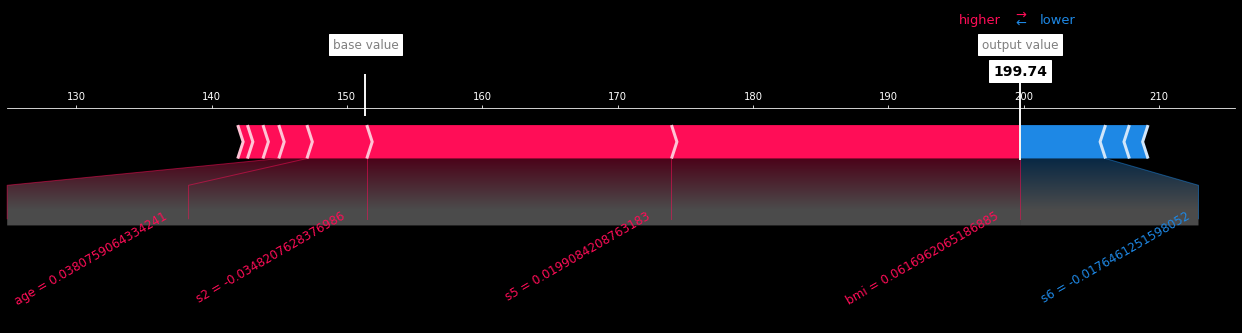

<Figure size 432x288 with 0 Axes>

In [44]:
# load JS visualization code to notebook
shap.initjs()

plt.style.use("_classic_test_patch")  

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True, figsize=(22, 4), \
                text_rotation=30)

plt.savefig('Shapley_1st_row.png')

In [45]:
# Perhaps the exact values are not readable from the plot, we can perhaps extract them in a table?
shap_vals = shap_values[0, :]
feature_importance = pd.DataFrame(list(zip(X.columns, shap_vals)), columns=['column_value','shap_vals'])
feature_importance.sort_values(by=['shap_vals'], ascending=False,inplace=True)
feature_importance

,column_value,shap_vals
2,bmi,25.764055
8,s5,22.507841
5,s2,4.422626
0,age,2.079691
3,bp,1.166731
6,s3,1.145981
4,s1,0.717997
7,s4,-1.380246
1,sex,-1.760257
9,s6,-6.296545


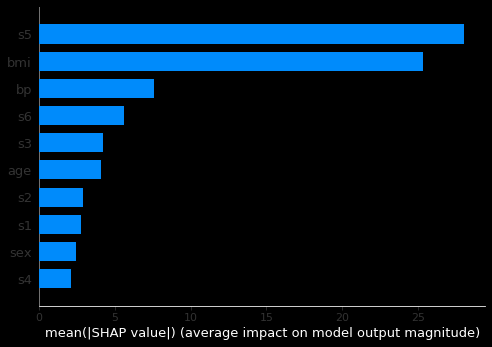

In [46]:
# Plot the features'average impact on the model output's magnitude
shap.summary_plot(shap_values, X, plot_type="bar")

The plot below shows the Shapley values for all the features and all instances in the dataset. It sorts features but the sum of the Shap value magnitudes over all samples, and shows the impact each feature has on the model output. 

Red color means high values, blue color means low value. The plot reveals, for example, that a high overall quality increases the predicted sale price.

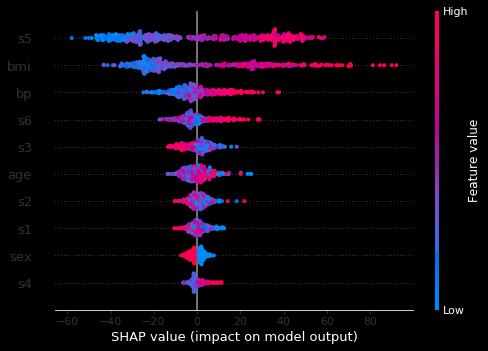

<Figure size 432x288 with 0 Axes>

In [49]:
# summarize the effects of all the features

shap.summary_plot(shap_values, X)
plt.savefig('shapley_vals.png')